# Comparison of Model-Free, SDM, LeMaster's Approach, and Detectors

In the following, we will load a data set consisting of $^{15}$N relaxation data acquired for ubiquitin in solution, and analyze it using five methods: Spectral Density Mapping, LeMaster's Approach, IMPACT, Detector Analysis (with and without removing tumbling), and Model-Free Analysis.

**The data is taken from:**

C. Charlier, S.N. Khan, T. Arquardsen, P. Pelupessy, V. Reiss, D. Sakellariou, G. Bodenhausen, F. Engelke, F. Ferrage. "Nanosecond time scale motions in proteins revealed by high-resolution NMR relaxometry." [*J. Am. Chem. Soc.* vol. 135, 18665-72 (2013)](https://pubs.acs.org/doi/10.1021/ja409820g).

(Thanks to Fabien for sharing)


**The methods used are:**

*Model-Free analysis*

Lipari, G. & Szabo, A. Model-free approach to the interpretation of nuclear magnetic resonance relaxation in macromolecules. 1. Theory and range of validity. [*J. Am. Chem. Soc.* vol. 104 4546–4559 (1982)](https://pubs.acs.org/doi/10.1021/ja00381a009)

*Spectral Density Mapping*

Peng, J. & Wagner, G. Mapping of Spectral Density Functions Using Heteronuclear NMR Relaxation Measurements. [*J. Magn. Res.* vol. 98 308–332 (1992)](https://www.sciencedirect.com/science/article/pii/002223649290135T)

*LeMaster's Approach*

LeMaster, D. M. Larmor frequency selective model free analysis of protein NMR relaxation. [*J. Biomol. NMR* vol. 6 366–374 (1995)](https://link.springer.com/article/10.1007/BF00197636)

*IMPACT*

Khan, S.N., Charlier, C., Augustyniak, R., Salvi, N., Dejean, V., Bodenhausen, G., Lequin, O., Pelupessy, P., Ferrage, F. Distribution of Pico- and Nanosecond Motions in Disordered Proteins from Nuclear Spin Relaxation. [*Biophys. J.* vol. 109 988-99 (2015)](https://doi.org/10.1016/j.bpj.2015.06.069)

*Detector Analysis*

Smith, A. A., Ernst, M. & Meier, B. H. Optimized ‘detectors’ for dynamics analysis in solid-state NMR. [*J. Chem. Phys.* vol. 148 045104 (2018)](https://aip.scitation.org/doi/full/10.1063/1.5013316)

Smith, A. A., Ernst, M., Meier, B. H. & Ferrage, F. Reducing bias in the analysis of solution-state NMR data with dynamics detectors. [*J. Chem. Phys.* vol. 151 034102 (2019)](https://aip.scitation.org/doi/full/10.1063/1.5111081)




In [2]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
import pyDR
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear as lstsq

pyDR.Defaults['zrange']=[-13,-6,200]

In [3]:
#Load the data
data=pyDR.IO.readNMR('ubi_soln.txt')
data.info['med_val']=None

#Split into one-field data for SDM, LeMaster's approach
data600=data.__copy__()
data600.del_exp([0,1,3,4,6,7])
data800=data.__copy__()
data800.del_exp([0,2,3,5,6,8])
data950=data.__copy__()
data950.del_exp([1,2,4,5,7,8])

## Spectral Density Mapping
Spectral density mapping is achieved simply by calculating linear combinations of the experimental relaxation rate constants at one field, as follows:
\begin{eqnarray}
J(0)&=&\frac{R_2-R_1/2-0.454\sigma_\mathrm{IS}}{\delta_\mathrm{IS}^2/2+2(\Delta\sigma_\mathrm{I}\omega_\mathrm{I})^2} \\
J(\omega_\mathrm{I})&=&\frac{R_1-1.249\sigma_\mathrm{IS}}{3(\delta_\mathrm{IS}/4)^2+(\Delta\sigma_\mathrm{I}\omega_\mathrm{I})^2/3} \\
J(0.870\omega_\mathrm{S})&=&\frac{16\sigma_\mathrm{IS}}{5\delta_\mathrm{IS}^2}
\end{eqnarray}

This results in the following windows, resulting from the spectral density calculated for a given value of $\tau_c$ and $(1–S^2)=1$.
\begin{equation}
J(\omega,\tau_c)=\frac25\frac{\tau_c}{1+(\omega\tau_c)^2}
\end{equation}

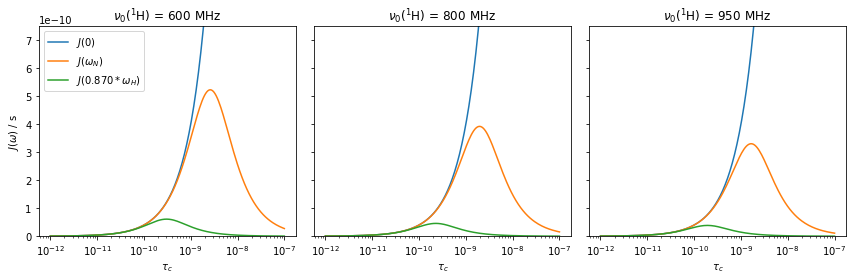

In [4]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches([12,4])
J=lambda omega,tc:2/5*tc/(1+(omega*tc)**2)
titles=(r'$J(0)$',r'$J(\omega_{N})$',r'$J(0.870*\omega_{H})$')

v0H0=[600,800,950]
rat=pyDR.tools.NucInfo('15N')/pyDR.tools.NucInfo('1H') #Ratio of 15N to 1H Larmor frequency
tc=np.logspace(-12,-7,200)
for v0H,a in zip(v0H0,ax):
    a.semilogx(tc,J(0,tc))
    a.semilogx(tc,J(v0H*2*np.pi*rat*1e6,tc))
    a.semilogx(tc,J(v0H*2*np.pi*0.87*1e6,tc))
    if a.is_first_col():
        a.set_ylabel(r'$J(\omega)$ / s')
    else:
        a.set_yticklabels('')
    a.set_ylim([0,0.75e-9])
    a.set_xlabel(r'$\tau_c$')
    a.set_title(r'$\nu_0(^1$H)'+f' = {v0H} MHz')
ax[0].legend(titles)
fig.tight_layout()

In [5]:
print(f'From the rotational correlation time, 4.84e-9 s, we estimate J(0) should be slightly less than {2/5*4.84e-9} s')

From the rotational correlation time, 4.84e-9 s, we estimate J(0) should be slightly less than 1.936e-09 s


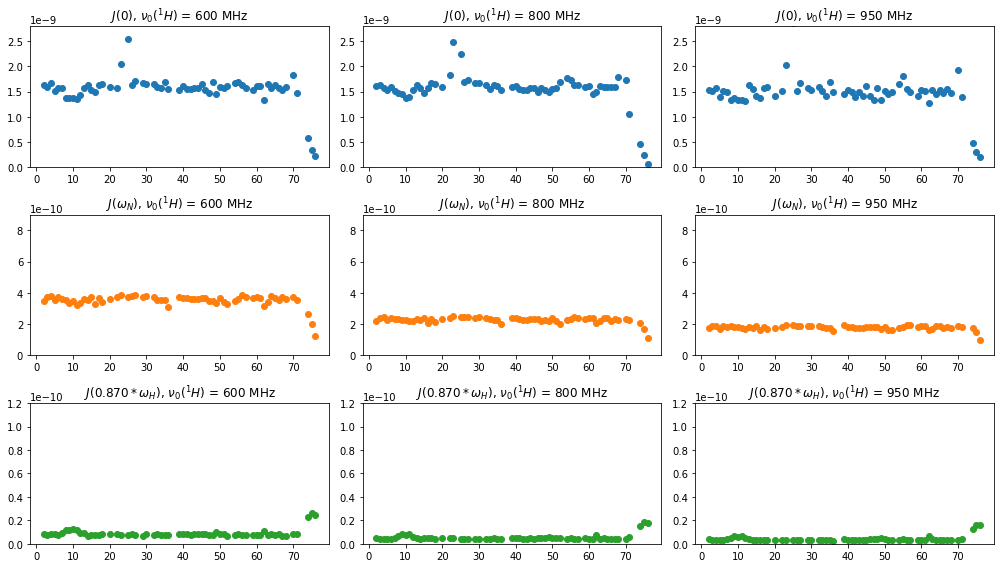

In [26]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches([14,8])

titles=(r'$J(0)$',r'$J(\omega_{N})$',r'$J(0.870*\omega_{H})$')

cm=plt.get_cmap('tab10')  #Color map (use for selecting colors)

delta=22954*2*np.pi/2  #rad/s
Del_sig=172   #ppm

J0=list()
JomegaI=list()
Jp87omegaS=list()
for v0H,d,a in zip(v0H0,[data600,data800,data950],ax.T):
    #data in d has residues down the columns and R1,NOE,R2 across the rows
    DSOmega=Del_sig*v0H*rat*2*np.pi   #DeltaSigma_I*omega_I  (rad/s)
    dd=delta
    c=Del_sig*v0H*rat*2*np.pi/np.sqrt(3)
    
    J0.append((d.R[:,2]-d.R[:,0]/2-0.454*d.R[:,1])/(3*dd**2+4*c**2)*6)
    JomegaI.append((d.R[:,0]-1.249*d.R[:,1])/(3*dd**2/4+c**2))
    Jp87omegaS.append(4*d.R[:,1]/(5*dd**2))
    
    for k,(J,title) in enumerate(zip([J0[-1],JomegaI[-1],Jp87omegaS[-1]],titles)):
        a[k].scatter(d.label,J,color=cm(k))
        a[k].set_title(title+r', $\nu_0(^1H)$'+f' = {v0H} MHz')
    a[0].set_ylim([0,2.8e-9])
    a[1].set_ylim([0,9e-10])
    a[2].set_ylim([0,1.2e-10])
fig.tight_layout()

Note that the spike in $J(0)$ at residues 21-23 is likely due to chemical exchange, and is not due to reorientional dynamics.

## LeMaster's Approach
LeMaster uses a similar approach, but fits the data to a model spectral density, which allows one to separate out the influence of tumbling from the internal motion.
\begin{eqnarray}
J(\omega)=
&\frac25&\left[\frac{\tau_M}{1+(\omega\tau_M)^2}+(1-S_f^2)\left(-\frac{\tau_M}{1+(\omega\tau_M)^2}\right)+\right.\\
&&\left.S_f^2(1-S_H^2)\left(\frac{\tau_H}{1+(\omega\tau_H)^2}-\frac{\tau_M}{1+(\omega\tau_M)^2}\right)+S_f^2S_H^2(1-S_N^2)\left(\frac{\tau_N}{1+(\omega\tau_N)^2}-\frac{\tau_M}{1+(\omega\tau_M)^2}\right)\right]
\end{eqnarray}
with
\begin{eqnarray}
\tau_H&=&(\omega_H+\omega_N)^{-1} \\
\tau_N&=&|\omega_N|^{-1}
\end{eqnarray}
Then, the parameters $1-S_f^2$, $S_f^2(1-S_H^2)$, and $S_f^2S_H^2(1-S_N^2)$ can be used to fit the relaxation rate constants or the spectral densities directly in a linear fit.

We'll use the results from the SDM, rather than trying to do the fits directly from the raw data.

We know from previously published results (Charlier et al.) that the rotational correlation time, $\tau_M$, is 4.84 ns

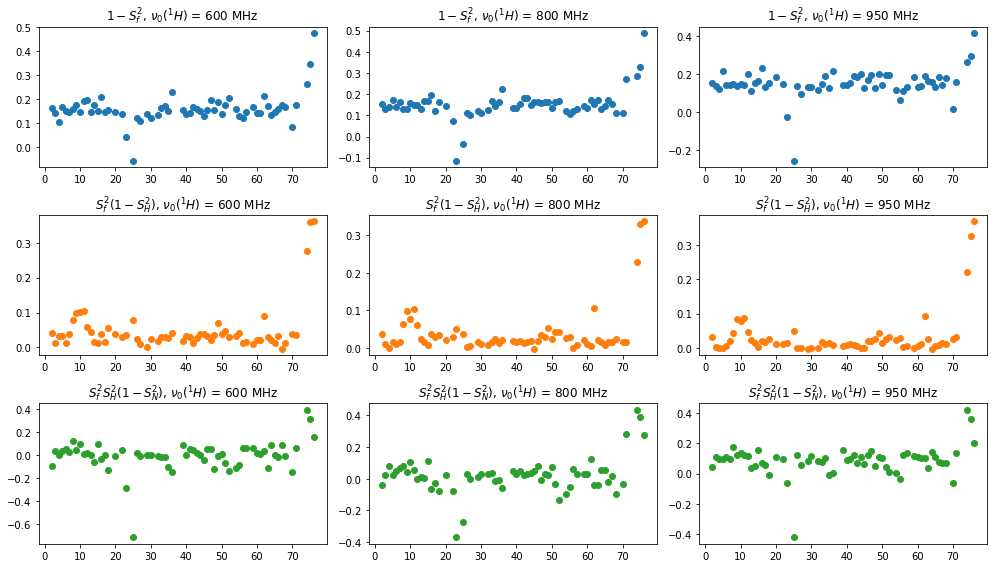

In [27]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches([14,8])

tM=4.84e-9  #Rotation diffusion correlation time / s

titles=(r'$1-S_f^2$',r'$S_f^2(1-S_H^2)$',r'$S_f^2S_H^2(1-S_N^2)$')

for v0H,J00,JomegaI0,Jp87omegaS0,a in zip(v0H0,J0,JomegaI,Jp87omegaS,ax.T):
    tH=1/(v0H*2*np.pi*1e6+v0H*rat*2*np.pi*1e6)
    tN=1/np.abs(v0H*rat*2*np.pi*1e6)
        
    omega0=[0,-v0H*rat*2*np.pi*1e6,0.87*v0H*2*np.pi*1e6]  #Frequencies sampled by SDM in rad/s
    
    offset=np.zeros(3)  #This is the offset term, 2/5*tM/(1+omega*tM)
    M=np.zeros((3,3))
    for k,omega in enumerate(omega0):
        offset[k]=2/5*tM/(1+(omega*tM)**2)
        #M@[(1-Sf2),Sf2*(1-SH2),Sf2*SH2*(1-SN2)] = [J0,JomegaN,0.87*JomegaH]
        M[k]=[-2/5*tM/(1+(omega*tM)**2),2/5*(tH/(1+(omega*tH)**2)-tM/(1+(omega*tM)**2)),
              2/5*(tN/(1+(omega*tN)**2)-tM/(1+(omega*tM)**2))]
    
    A0=np.linalg.pinv(M)@(np.array([J00,JomegaI0,Jp87omegaS0]).T-offset).T
#     A0=np.array([lsq(M,b)['x'] for b in np.array([J00,JomegaI0,Jp87omegaS0]).T-offset]).T
    
    for k,(A,title) in enumerate(zip(A0,titles)):
        a[k].scatter(d.label,A,color=cm(k))
        a[k].set_title(title+r', $\nu_0(^1H)$'+f' = {v0H} MHz')
fig.tight_layout()
       

## IMPACT Analysis of full data set
IMPACT assumes a correlation function which is a sum of several correlation times, where the sum of weights for the terms is 1. We will assume four correlation times here, such that
\begin{eqnarray}
C(t)&=&\frac25\sum\limits_{i=1}^4{A_ie^{-t/\tau_i}} \\
1&=&\sum\limits_{i=1}^4{A_i} \\
0&\le&A_i\le1
\end{eqnarray}

Text(0.5, 1.0, 'Data Fit')

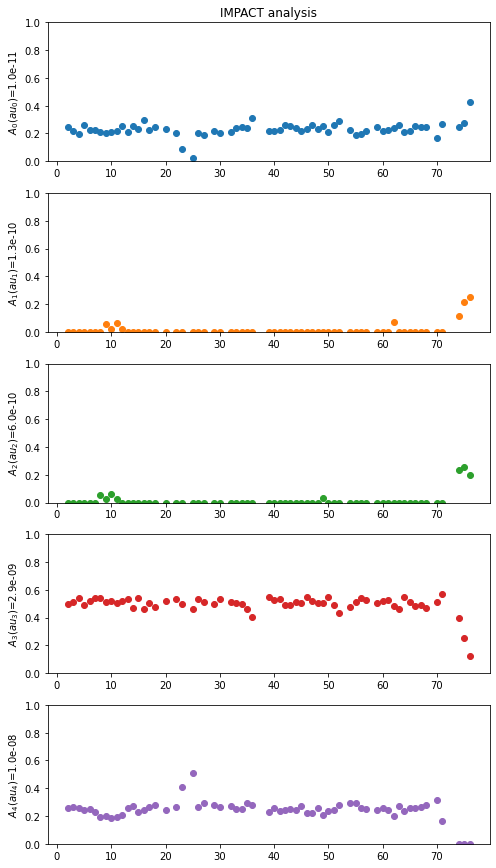

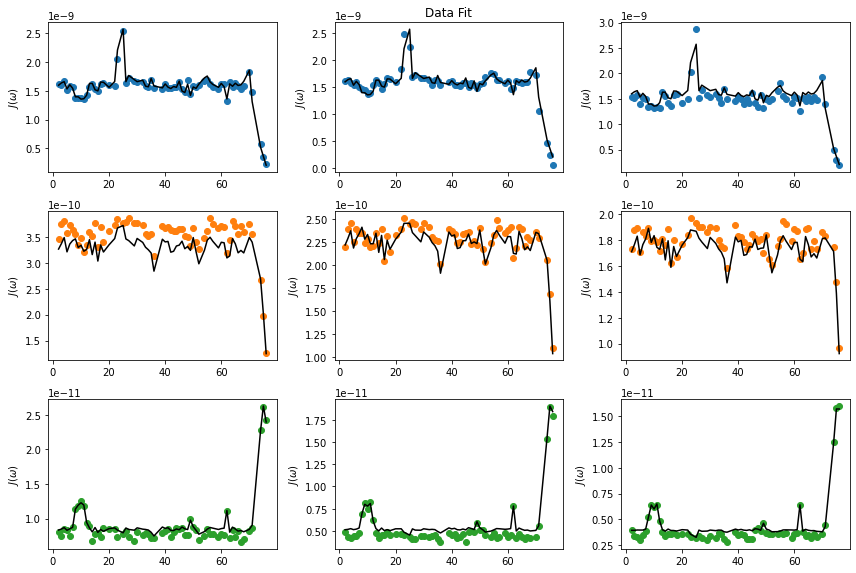

In [100]:
#I cheated a little bit here...
#I took the correlation times from the detector analysis below for the middle 3 values
#And then manually optimized the last and put the first to just a short correlation time
tau=10**np.array([-11,-9.9002036,-9.2239323,-8.5449795,-8]) #Array of correlation times
J=np.array([*J0,*JomegaI,*Jp87omegaS]) #Collect all spectra densities
norm=J.mean(1)  #Use for reweighting
omega=np.array([0,0,0,*(-rat*np.array(v0H0)),*(0.87*np.array(v0H0))])*1e6*2*np.pi

q=10

M=np.zeros([10,len(tau)])
for k,tau0 in enumerate(tau):
    M[:-1,k]=2/5*tau0/(1+(omega*tau0)**2)/norm
    M[-1,k]=q  #We'll use this position to enforce the sum of the Ai to 1

A=np.zeros([len(tau),J.shape[1]])
Jc=np.zeros(J.shape)
for k,X in enumerate(J.T):
    target=np.array([*(X/norm),q])
    out=lstsq(M,target,bounds=(0,1))
    A[:,k]=out['x']
    Jc[:,k]=(M@A[:,k])[:-1]*norm

fig,ax=plt.subplots(len(tau),1)
fig.set_size_inches([7,12])
for k,(a,A0) in enumerate(zip(ax,A)):
    a.scatter(data.label,A0,color=cm(k))
    a.set_ylim([0,1])
    a.set_ylabel(r'$A_{'+str(k)+'} (\tau_{'+str(k)+'})$'+f'={tau[k]:.1e}')
fig.tight_layout()
ax[0].set_title('IMPACT analysis')

fig,ax=plt.subplots(3,3)
fig.set_size_inches([12,8])
for k,(a,X,Xc) in enumerate(zip(ax.flatten(),J,Jc)):
    a.scatter(data.label,X,color=cm(k//3))
    a.plot(data.label,Xc,color='black')
    a.set_ylabel(r'$J(\omega)$')
fig.tight_layout()
ax[0,1].set_title('Data Fit')

## One-field detector analysis, first without removing tumbling

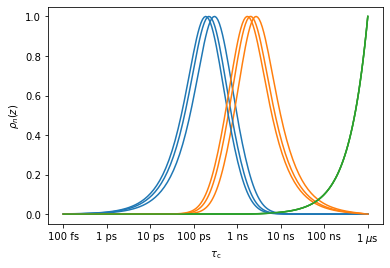

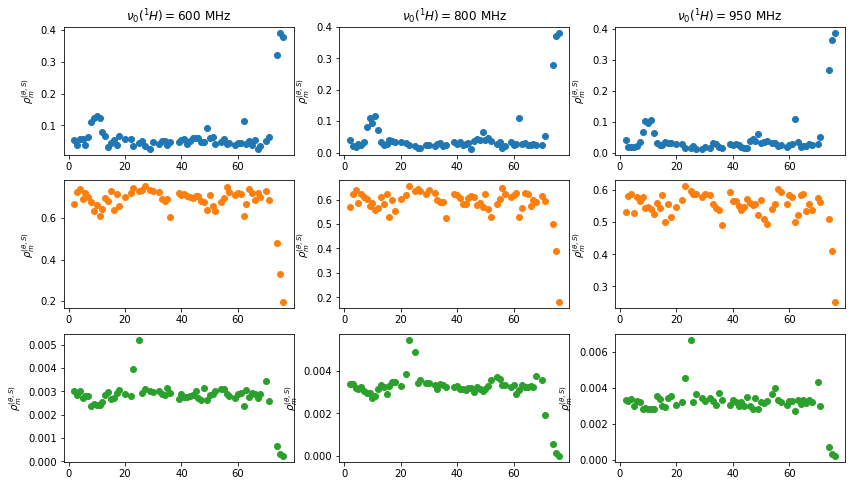

In [46]:
ax_sens=plt.subplots()[1]
fig,ax=plt.subplots(3,3)
fig.set_size_inches([14,8])
for k,(d,v0H,a) in enumerate(zip([data600,data800,data950],v0H0,ax.T)):
    #When loaded, a "solution-state" sensitivity is loaded, and includes tumbling influence
    #For the initial analysis, we replace this with a sensitivity that does not consider tumbling
    d.sens=pyDR.Sens.NMR(info=d.sens.info)
    d.detect.r_auto(3)
    fit=d.fit(bounds=True)
    fit.sens.plot_rhoz(ax=ax_sens,color=[cm(m) for m in range(3)])
    for m in range(3):
        a[m].scatter(fit.label,fit.R[:,m],color=cm(m))
        a[m].set_ylabel(r'$\rho_m^{(\theta,S)}$')
    a[0].set_title(r'$\nu_0(^1H) = $'+f'{v0H} MHz')

## One-field detector analysis, including removing tumbling

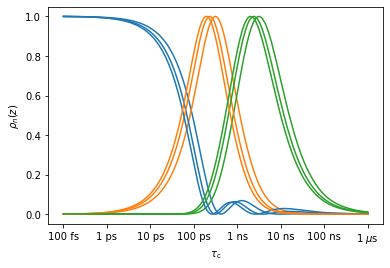

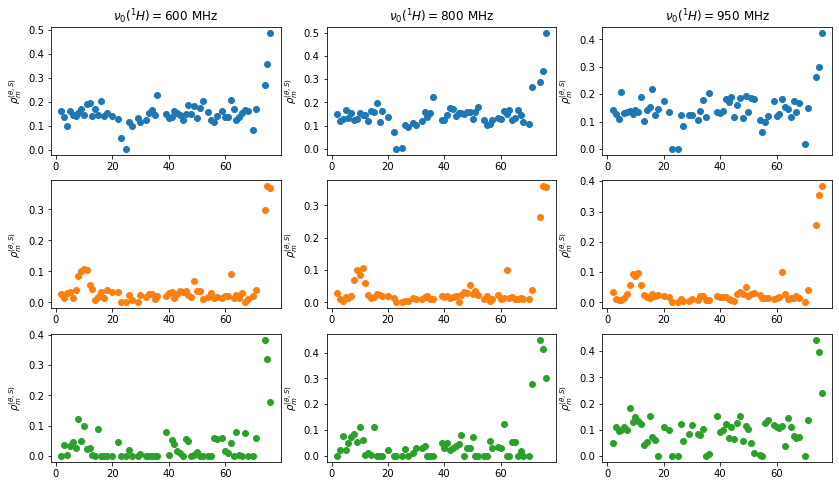

In [47]:
ax_sens=plt.subplots()[1]
fig,ax=plt.subplots(3,3)
fig.set_size_inches([14,8])
for k,(d,v0H,a) in enumerate(zip([data600,data800,data950],v0H0,ax.T)):
    #When loaded, a "solution-state" sensitivity is loaded, and includes tumbling influence
    #For the initial analysis, we replace this with a sensitivity that does not consider tumbling
    d.sens=pyDR.Sens.SolnNMR(info=d.sens.info)
    d.detect.r_auto(3)
    fit=d.fit(bounds=True)
    fit.sens.plot_rhoz(ax=ax_sens,color=[cm(m) for m in range(3)])
    for m in range(3):
        a[m].scatter(fit.label,fit.R[:,m],color=cm(m))
        a[m].set_ylabel(r'$\rho_m^{(\theta,S)}$')
    a[0].set_title(r'$\nu_0(^1H) = $'+f'{v0H} MHz')

## Detector Analysis of full data set without removing tumbling

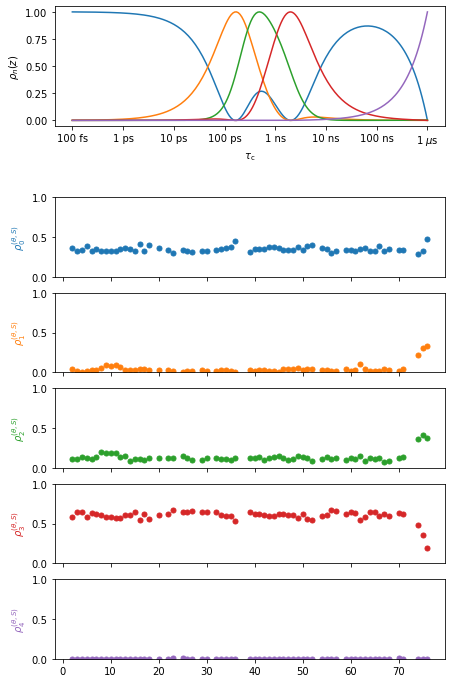

In [104]:
data.sens=pyDR.Sens.NMR(info=data.sens.info)
data.S2=np.zeros(data.R.shape[0])
data.S2std=np.ones(data.R.shape[0])*.01
data.detect.r_auto(4).inclS2()
fit=data.fit()
plt_obj=fit.plot(style='scatter')
plt_obj.fig.set_size_inches([7,12])
for a in plt_obj.ax:a.set_ylim([0,1])

## Detector Analysis of full data set including removing tumbling

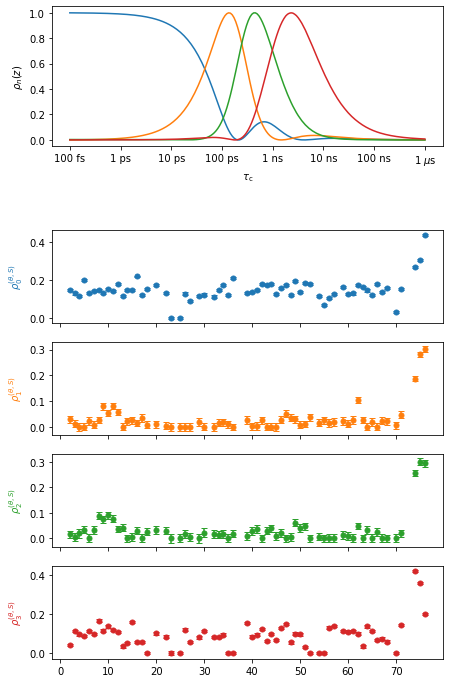

In [55]:
zmax=[-14,*fit.info['zmax'][:-1]]
data.sens=pyDR.Sens.SolnNMR(info=data.sens.info)
data.detect.r_auto(4)
fit=data.fit()
fit.plot(style='scatter',errorbars=True).fig.set_size_inches([7,12])

## Model-free analysis of full data set
While one typically performs a fit of the experimental data using model-free analysis, it is actually faster and easier once one already has a detector analysis. We use the built-in pyDR tools for model-free analysis here

1 of 4 iterations
2 of 4 iterations
3 of 4 iterations
4 of 4 iterations


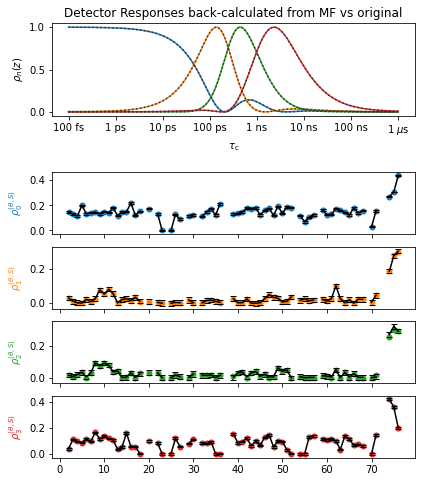

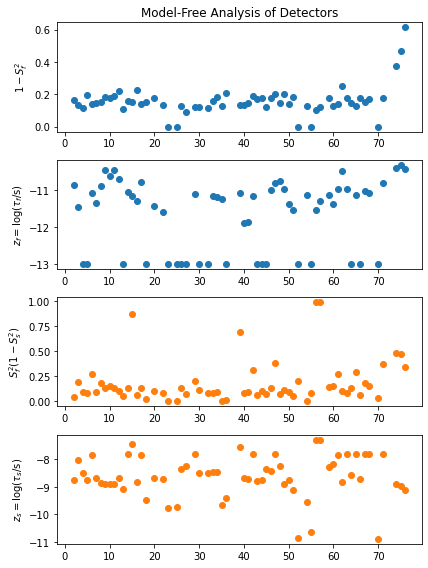

In [88]:
from pyDR.Fitting.fit import model_free
z,A,error,dfit=model_free(fit,nz=2)

plt_obj=fit.plot(style='scatter')
plt_obj.append_data(dfit)
plt_obj.ax_sens.set_title('Detector Responses back-calculated from MF vs original')
plt_obj.fig.set_size_inches([6.5,8])

fig,ax=plt.subplots(4,1)
fig.set_size_inches([6,8])
ax[0].scatter(fit.label,A[0],color=cm(0))
ax[0].set_ylabel(r'$1-S_f^2$')
ax[1].scatter(fit.label,z[0],color=cm(0))
ax[1].set_ylabel(r'$z_f=\log(\tau_f$/s)')
ax[2].scatter(fit.label,A[1],color=cm(1))
ax[2].set_ylabel(r'$S_f^2(1-S_s^2)$')
ax[3].scatter(fit.label,z[1],color=cm(1))
ax[3].set_ylabel(r'$z_s=\log(\tau_s$/s)')
ax[0].set_title('Model-Free Analysis of Detectors')
fig.tight_layout()